In [1]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from graph.precision_recall import precision_recall

In [3]:
def get_n_nearest(data, columns, corr = False, number_close=5):
    groups = []
    if corr:
        for c in columns:
            close_ind = data[c].sort_values(ascending=False).index.tolist()
            groups.append(close_ind[0:number_close+1])
    else:
        for c in columns:
            close_ind = data[c].sort_values().index.tolist()
            groups.append(close_ind[0:number_close+1])

    return groups

In [77]:
df = pd.read_csv('pathfinder.csv')
df

,Fault,F1,F97,F2,F78,F3,F4,F5,F53,F6,...,F99,F100,F105,F101,F102,F103,F104,F106,F107,F108
0,-0.242125,0.099410,-1.781273,-1.775080,-1.550274,-4.864918,-1.081013,-3.280087,0.817510,-0.179524,...,-2.427341,-3.938991,-1.068118,-0.793409,0.303527,-2.117373,-2.259300,-4.320812,-1.894678,0.608591
1,0.753410,1.765145,1.935084,2.494032,2.903560,3.476969,3.160170,4.807073,0.804229,0.735966,...,0.350456,7.467613,3.373766,4.723972,2.284384,2.709317,1.764132,3.731937,2.773729,-0.925589
2,-0.127051,1.043907,-0.186284,-0.032315,-0.115591,0.154713,-0.763539,-1.119711,1.917498,1.951901,...,-0.866530,0.196432,0.718974,0.660171,2.584675,0.404964,-2.105698,-0.853934,-1.351905,-1.086142
3,-0.357740,-0.537735,0.582915,0.236852,3.020667,3.025861,0.387631,-0.176486,-1.215239,-2.104040,...,1.529078,0.511368,-0.491282,-1.728069,-1.118330,-1.125264,1.822804,-0.114046,-0.297576,0.456902
4,-0.511176,-0.544420,-1.372587,-1.667810,-1.081624,-3.317511,-1.302753,-4.094588,0.072739,-1.265747,...,-1.092012,-3.809236,-2.221467,-4.002726,-3.373330,-3.289154,-0.771552,-1.136297,-2.708188,-0.257007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.139180,-1.312675,0.317400,-0.757778,0.133704,1.507697,0.823872,-0.343314,-0.238615,1.018854,...,-1.457835,1.526064,-0.589175,-0.828458,-0.171100,1.734815,1.512160,-0.214233,-0.036535,-0.501424
996,-0.202199,-0.503377,1.724128,1.287135,0.257843,2.821003,-0.716170,3.656351,-0.480276,0.762738,...,5.069980,1.474990,-0.799021,-1.514926,-1.035523,1.465593,1.383168,2.546570,-0.850396,-0.716659
997,0.462421,0.633488,-1.044363,-1.077563,-1.888324,-2.107271,0.388854,-1.601745,-0.376310,1.352616,...,-0.928932,-2.037652,-3.094545,-2.997040,-2.590712,0.601864,-1.756386,-2.603180,-0.939630,0.655891
998,-0.326953,-0.038649,-1.590028,-2.873125,-2.414704,-3.957700,-1.559489,-3.354033,0.168321,0.841487,...,-2.889445,-4.472910,-0.312238,0.361622,-1.037624,-2.691893,-1.274928,-2.321980,0.824082,0.008544


In [78]:
node_type = get_nodes_type(df)

In [79]:
df_discrete, est = discretization(df, 'equal_frequency', df.columns)
df_discrete

,Fault,F1,F97,F2,F78,F3,F4,F5,F53,F6,...,F99,F100,F105,F101,F102,F103,F104,F106,F107,F108
0,2,2,0,1,1,0,1,1,3,2,...,1,1,1,2,2,1,0,0,1,3
1,3,4,4,4,4,3,4,4,3,3,...,2,4,4,4,3,4,3,4,4,1
2,2,3,2,2,2,2,1,2,4,3,...,2,2,3,3,3,2,1,1,1,1
3,1,1,3,2,4,3,2,2,0,0,...,3,2,2,1,1,1,3,2,2,3
4,1,1,0,1,1,1,1,0,2,1,...,2,1,0,0,0,0,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,2,1,2,3,3,2,2,3,...,1,3,2,2,2,3,3,2,2,1
996,2,1,4,3,2,3,2,3,1,3,...,4,3,1,1,2,3,3,4,2,1
997,3,3,1,1,1,1,2,1,1,3,...,2,1,0,1,1,3,1,0,2,3
998,1,2,0,0,0,1,1,1,2,3,...,1,0,2,2,2,0,1,0,3,2


<AxesSubplot:>

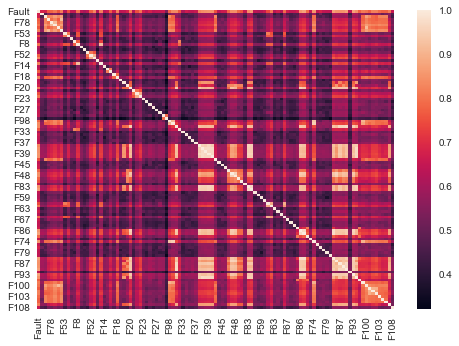

In [85]:
corr = df_discrete.corr(method='spearman')
sns.heatmap(corr)

In [86]:
groups = get_n_nearest(corr, df.columns, corr=True, number_close=7)

In [87]:
brave = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
brave.index = df.columns

In [88]:
for c1 in df.columns:
    for c2 in df.columns:
        a = 0
        b = 0
        c = 0
        d = 0
        if c1 != c2:
            for g in groups:
                if (c1 in g) & (c2 in g):
                    a += 1
                if (c1 in g) & (c2 not in g):
                    b += 1
                if (c1 not in g) & (c2 in g):
                    c += 1
                if (c1 not in g) & (c2 not in g):
                    d += 1
            br = (a*len(groups) + (a+c)*(a+b)) / ((math.sqrt((a + c + 0.00000001)*(b+d + 0.00000001))) * (math.sqrt((a+b + 0.00000001)*(c+d + 0.00000001))))
            brave.loc[c1,c2] = br

<AxesSubplot:>

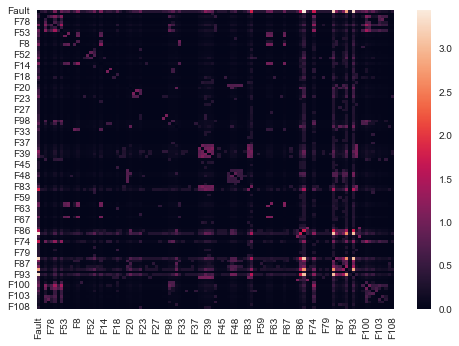

In [89]:
sns.heatmap(brave)

In [90]:
possible_edges = []
for c1 in df.columns:
    for c2 in df.columns:
        if brave.loc[c1, c2] > 1.5:
            possible_edges.append((c1, c2))

In [91]:
bn = structure_learning(df_discrete, 'HC', node_type, 'K2', white_list=possible_edges)

In [16]:
true_net = pd.read_csv('pathfindertruen.csv')
true_net

,arcs.from,arcs.to
0,Fault,F1
1,Fault,F2
2,Fault,F3
3,Fault,F4
4,Fault,F5
...,...,...
190,F91,F96
191,F92,F94
192,F93,F94
193,F101,F102


In [17]:
structure_right = []
for i in true_net.index:
    structure_right.append([true_net.loc[i,'arcs.from'], true_net.loc[i,'arcs.to']])

In [92]:
brave_edgse = []
for e in bn['E']:
    brave_edgse.append((e[0], e[1]))

In [38]:
sparsebn_net = pd.read_csv('sparsebnsolutionedgelist.csv')
sparsebn_net = sparsebn_net[['Fault',	'F1']]
sparsebn_net

,Fault,F1
0,Fault,F4
1,Fault,F5
2,Fault,F6
3,Fault,F7
4,Fault,F9
...,...,...
183,F106,F102
184,F107,F103
185,F108,F59
186,F109,F2


In [39]:
sparsebn_net.loc[188,'Fault'] = 'Fault'
sparsebn_net.loc[188,'F1'] = 'F1'

In [40]:
sparsebn_net.columns = ['arcs.from', 'arcs.to']

In [42]:
structure_sparsebn = []
for i in sparsebn_net.index:
    structure_sparsebn.append([sparsebn_net.loc[i,'arcs.from'], sparsebn_net.loc[i,'arcs.to']])

In [93]:
precision_recall(brave_edgse, structure_right)

{'AP': 0.3, 'AR': 0.02, 'AHP': 0.1, 'AHR': 0.01, 'SHD': 201}

In [43]:
precision_recall(structure_sparsebn, structure_right)

{'AP': 0.46, 'AR': 0.44, 'AHP': 0.45, 'AHR': 0.44, 'SHD': 213}